
# Dental No-Show Prediction: PTS Analysis

**Workflow:** Exploration → Features → Model → AUC-ROC Score

**Target Buckets:** High (<0.50) • Medium (0.50-0.79) • Low (≥0.80)

In [37]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import joblib
import warnings
warnings.filterwarnings('ignore')

# Production modules
import sys
sys.path.append('.')
from core.training import DataLoader, FeatureEngineer
from common.utils import predict_bucket

## 1. Data Exploration

In [38]:
# Load data
data_loader = DataLoader()
patients, providers, appointments, phone_calls = data_loader.load_data()

print(f"Dataset: {appointments.shape[0]:,} appointments, {patients.shape[0]:,} patients")
print(f"No-Show Rate: {len(appointments[appointments['status'] == 'No-Show']) / len(appointments):.1%}")
print("Status Distribution:")
print(appointments['status'].value_counts())

Dataset: 12,000 appointments, 2,000 patients
No-Show Rate: 11.8%
Status Distribution:
status
Completed    9376
No-Show      1412
Cancelled    1212
Name: count, dtype: int64


## 2. Feature Engineering

In [39]:
# Create features using production pipeline
feature_engineer = FeatureEngineer()
training_data = feature_engineer.create_training_features(patients, providers, appointments, phone_calls)
X, y = feature_engineer.prepare_features_and_target(training_data)

print(f"Features: {X.shape[0]:,} samples × {X.shape[1]} features")
print(f"Target: {y.sum():,} no-shows ({y.mean():.1%})")
print(f"Feature Categories: Demographics, Geographic, Risk, Historical, Engagement, Financial")

Features: 12,000 samples × 20 features
Target: 1,412 no-shows (11.8%)
Feature Categories: Demographics, Geographic, Risk, Historical, Engagement, Financial


## 3. Model Evaluation

In [40]:
# Load trained model
model_data = joblib.load('models/prediction_model.pkl')
model = model_data['model'] if isinstance(model_data, dict) else model_data
print(f"Model: {type(model).__name__}")

Model: AdaBoostClassifier


In [41]:
# Train/test split and evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"Production Ready: {'Yes' if auc_score >= 0.75 else 'No'}")
print(f"Test Set: {X_test.shape[0]:,} samples")

AUC-ROC Score: 0.8506
Production Ready: Yes
Test Set: 2,400 samples


In [42]:
# Feature importance
if hasattr(model, 'feature_importances_'):
    importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 5 Features:")
    for _, row in importance.head(5).iterrows():
        print(f"  {row['feature']}: {row['importance']:.3f}")

Top 5 Features:
  no_show_rate: 0.956
  appointment_encoded: 0.044
  call_count: 0.000
  booking_encoded: 0.000
  insurance_encoded: 0.000


## 4. AUC-ROC Visualization

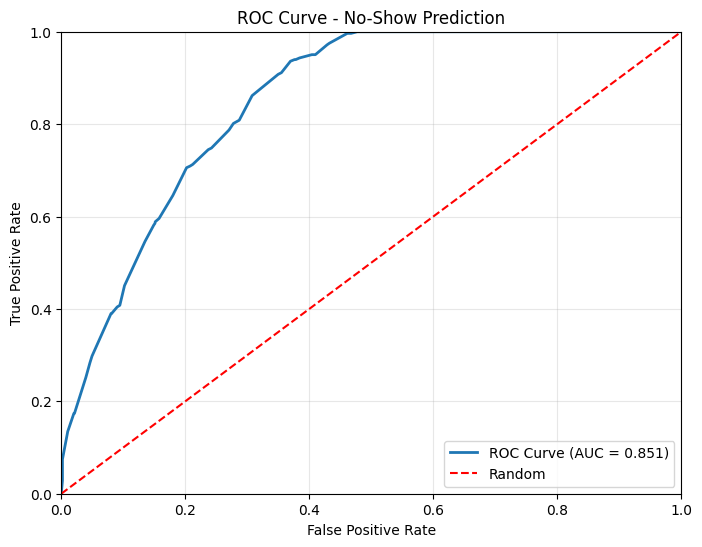

In [43]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - No-Show Prediction')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

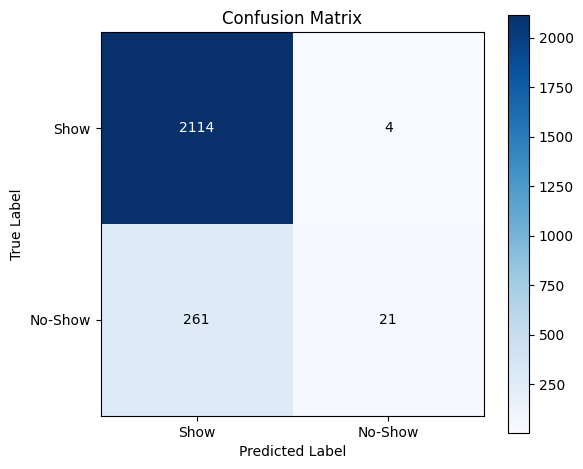

In [44]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Show', 'No-Show'])
plt.yticks(tick_marks, ['Show', 'No-Show'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add numbers to confusion matrix
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

## 5. PTS Bucket System

In [45]:
# Convert predictions to PTS buckets
bucket_results = []
for i, prob in enumerate(y_pred_proba):
    pts_score = 1 - prob  # Convert no-show prob to PTS
    risk_bucket = predict_bucket(pts_score)
    bucket_results.append({
        'pts_score': pts_score,
        'risk_bucket': risk_bucket,
        'actual_no_show': y_test.iloc[i]
    })

bucket_df = pd.DataFrame(bucket_results)
print("Bucket Distribution:")
print(bucket_df['risk_bucket'].value_counts())

Bucket Distribution:
risk_bucket
Medium    2375
High        25
Name: count, dtype: int64


In [46]:
# Bucket validation
validation = bucket_df.groupby('risk_bucket')['actual_no_show'].agg(['count', 'mean'])
validation.columns = ['Patients', 'NoShow_Rate']
validation['Actual_PTS'] = 1 - validation['NoShow_Rate']

print("Bucket Performance:")
for bucket in ['High', 'Medium', 'Low']:
    if bucket in validation.index:
        pts = validation.loc[bucket, 'Actual_PTS']
        count = validation.loc[bucket, 'Patients']
        print(f"  {bucket} Risk: {count} patients, {pts:.3f} actual PTS")

Bucket Performance:
  High Risk: 25 patients, 0.160 actual PTS
  Medium Risk: 2375 patients, 0.890 actual PTS


In [47]:
# Example predictions
examples = [0.15, 0.35, 0.65, 0.85]
print("Example Predictions:")
for pts in examples:
    bucket = predict_bucket(pts)
    print(f"  PTS: {pts:.2f} → {bucket} Risk")

Example Predictions:
  PTS: 0.15 → High Risk
  PTS: 0.35 → High Risk
  PTS: 0.65 → Medium Risk
  PTS: 0.85 → Low Risk
